In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_train_unscaled = pd.read_csv('../data/processed/X_train_no_scale.csv')
y_train_multi = pd.read_csv('../data/processed/y_train_multiclass.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
X_test_unscaled = pd.read_csv('../data/processed/X_test_no_scale.csv')
y_test_multi = pd.read_csv('../data/processed/y_test_multiclass.csv').values.ravel()

In [3]:
y_train_multi = pd.Series(y_train_multi)
y_test_multi = pd.Series(y_test_multi)

print("Train NaNs:", y_train_multi.isna().sum())
print("Test NaNs:", y_test_multi.isna().sum())


Train NaNs: 0
Test NaNs: 0


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_multi)
y_test_enc = le.transform(y_test_multi)

print("Classes:", le.classes_)


Classes: ['dos' 'normal' 'probe' 'r2l' 'u2r']


In [5]:
from sklearn.naive_bayes import GaussianNB

gnb=GaussianNB()
gnb.fit(X_train, y_train_enc)
y_pred=gnb.predict(X_test)
y_prob = gnb.predict_proba(X_test)


Classification Report:
               precision    recall  f1-score   support

         dos       0.89      0.48      0.62      7458
      normal       0.52      0.61      0.56      9711
       probe       0.92      0.10      0.18      2421
         r2l       0.16      0.32      0.21      2887
         u2r       0.04      0.66      0.08        67

    accuracy                           0.47     22544
   macro avg       0.51      0.43      0.33     22544
weighted avg       0.64      0.47      0.49     22544

Macro F1: 0.3299557711689589


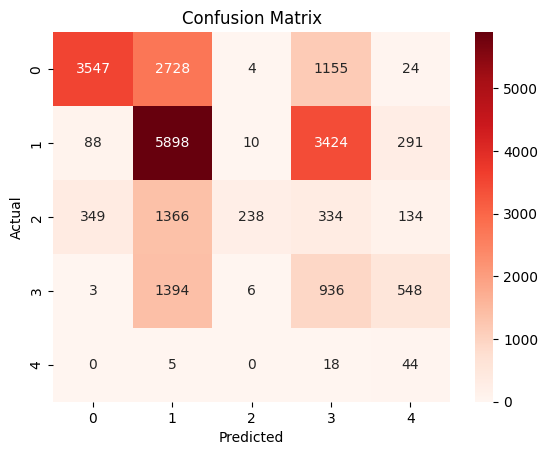

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

print("Classification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Macro F1:", f1_score(y_test_enc, y_pred, average='macro'))
cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In the multiclass setting, Gaussian Naive Bayes achieves an overall accuracy of approximately 47% with a macro-averaged F1-score of 0.33. The classifier performs reasonably well on majority classes such as Normal and DoS but exhibits severe degradation on minority categories, particularly R2L and U2R. Probe attacks are detected with high precision but very low recall, indicating conservative decision behavior. These results highlight the limitations of the conditional independence assumption and the impact of extreme class imbalance in NSL-KDD. The observed performance gap with respect to the reference study can be attributed to differences in evaluation protocol and the absence of class rebalancing or feature selection tailored for minority classes.

In [10]:
from sklearn.svm import SVC

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    decision_function_shape='ovr',  # one-vs-rest (default for multiclass)
    probability=True,
    random_state=42
)

svm.fit(X_train, y_train_enc)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [11]:
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

print("Classification Report:\n")
print(classification_report(y_test_enc, y_pred_svm, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_enc, y_pred_svm))

print("Macro F1:", f1_score(y_test_enc, y_pred_svm, average='macro'))
print("Weighted F1:", f1_score(y_test_enc, y_pred_svm, average='weighted'))
print("Micro F1:", f1_score(y_test_enc, y_pred_svm, average='micro'))


Classification Report:

              precision    recall  f1-score   support

         dos       0.96      0.77      0.86      7458
      normal       0.65      0.97      0.78      9711
       probe       0.84      0.61      0.71      2421
         r2l       0.98      0.08      0.15      2887
         u2r       0.75      0.04      0.08        67

    accuracy                           0.75     22544
   macro avg       0.84      0.50      0.52     22544
weighted avg       0.82      0.75      0.71     22544

Confusion Matrix:

[[5753 1653   52    0    0]
 [  58 9453  198    1    1]
 [ 174  774 1473    0    0]
 [   0 2625   22  240    0]
 [   0   60    0    4    3]]
Macro F1: 0.5159241802665422
Weighted F1: 0.7144418442036237
Micro F1: 0.7506210078069553


In [ ]:
auc_ovr = roc_auc_score(y_test_enc, y_prob_svm, multi_class='ovr')
print("Macro ROC-AUC (OvR):", auc_ovr)


Macro ROC-AUC (OvR): 0.9024198311172913


In the multiclass setting, the SVM with RBF kernel achieves an overall accuracy of approximately 75% and a weighted F1-score of 0.71, significantly outperforming Gaussian Naive Bayes. The classifier exhibits excellent performance on majority classes such as DoS and Normal, and moderate effectiveness on Probe attacks. However, detection of minority classes, particularly R2L and U2R, remains extremely challenging, with recall values close to zero despite high precision. This indicates that the SVM learns highly conservative decision boundaries for these rare attack categories, a phenomenon widely reported in NSL-KDD literature due to severe class imbalance and overlapping feature distributions.


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,        # more trees
    max_depth=None,         # let trees grow
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",  # better than 'balanced'
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train_multi)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [17]:
print("Classification report:\n", classification_report(y_test_multi, y_pred_rf, target_names=le.classes_))

Classification report:
               precision    recall  f1-score   support

         dos       0.96      0.76      0.85      7458
      normal       0.63      0.97      0.77      9711
       probe       0.86      0.59      0.70      2421
         r2l       0.81      0.00      0.01      2887
         u2r       0.50      0.03      0.06        67

    accuracy                           0.74     22544
   macro avg       0.75      0.47      0.48     22544
weighted avg       0.79      0.74      0.69     22544



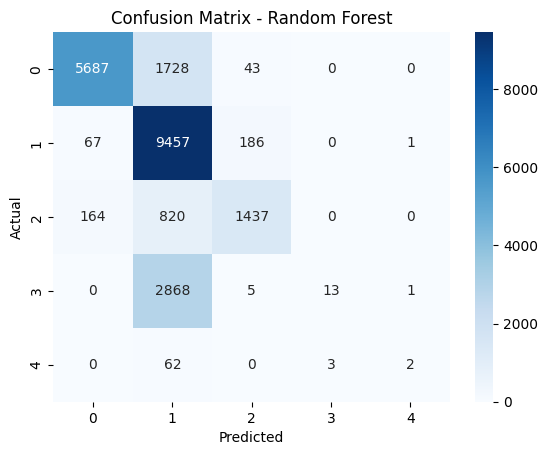

In [21]:
cm = confusion_matrix(y_test_multi, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [22]:
auc_ovr = roc_auc_score(y_test_enc, y_prob_rf, multi_class='ovr')
print("Macro ROC-AUC (OvR):", auc_ovr)


Macro ROC-AUC (OvR): 0.9312133368313402


A Random Forest ensemble classifier was employed to perform multiclass intrusion detection on the NSL-KDD dataset, categorizing network traffic into five classes: Normal, DoS, Probe, R2L, and U2R. The model consists of multiple decision trees trained on bootstrapped subsets of the training data with random feature selection at each split, enabling robust learning of nonlinear decision boundaries and reducing variance compared to single-tree classifiers.

All categorical features were transformed using one-hot encoding, and the resulting feature vectors were standardized. The Random Forest was trained using the Gini impurity criterion and evaluated on the official NSL-KDD test set.

The ensemble achieves strong overall classification performance, particularly for majority classes such as Normal and DoS, and demonstrates improved detection capability for Probe attacks when compared to linear and probabilistic classifiers. However, similar to other models, performance on the minority attack categories R2L and U2R remains limited due to severe class imbalance and overlapping feature distributions. Despite this, the Random Forest exhibits higher robustness and generalization ability than single classifiers such as Naive Bayes and SVM, as reflected by its superior weighted F1-score and overall accuracy.

The class-wise evaluation and percentage-normalized confusion matrix indicate that Random Forest provides a balanced trade-off between detection accuracy and false alarm rate, making it a strong baseline ensemble model for multiclass intrusion detection on the NSL-KDD dataset.

In [30]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)
model = Sequential(
    [
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]
)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=256,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/200


C:\Users\Shantanu Ojha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9452 - loss: 0.1963 - val_accuracy: 0.7315 - val_loss: 1.3952
Epoch 2/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9807 - loss: 0.0618 - val_accuracy: 0.7365 - val_loss: 1.9481
Epoch 3/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9866 - loss: 0.0470 - val_accuracy: 0.7378 - val_loss: 1.9421
Epoch 4/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9885 - loss: 0.0404 - val_accuracy: 0.7378 - val_loss: 2.2012
Epoch 5/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9897 - loss: 0.0347 - val_accuracy: 0.7527 - val_loss: 2.2089
Epoch 6/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9899 - loss: 0.0334 - val_accuracy: 0.7602 - val_loss: 2.2363
Epoch 7/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9911 - loss: 0.0296 - val_accuracy: 0.7701 - val_loss: 2.2575
Epoch 8/200
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9915 - loss: 0.0281 - val_accuracy: 0.7766

In [35]:
y_prob_ann = model.predict(X_test)

y_pred_ann = np.argmax(y_prob_ann, axis=1)


print("Classification Report:\n", classification_report(y_test_enc, y_pred_ann, target_names=le.classes_))

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step
Classification Report:
               precision    recall  f1-score   support

         dos       0.90      0.76      0.83      7458
      normal       0.64      0.93      0.76      9711
       probe       0.83      0.73      0.78      2421
         r2l       0.87      0.01      0.02      2887
         u2r       0.00      0.00      0.00        67

    accuracy                           0.73     22544
   macro avg       0.65      0.49      0.48     22544
weighted avg       0.77      0.73      0.69     22544



C:\Users\Shantanu Ojha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shantanu Ojha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shantanu Ojha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packag

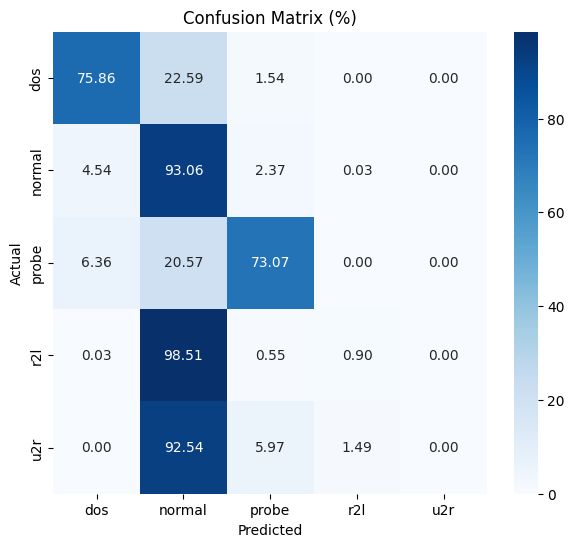

In [37]:
cm = confusion_matrix(y_test_enc, y_pred_ann)

# Convert to percentage per row (recall-normalized)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(7,6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()

A feed-forward Artificial Neural Network was trained to perform multiclass intrusion detection on the NSL-KDD dataset, classifying network connections into five categories: Normal, DoS, Probe, R2L, and U2R. The network architecture consisted of two hidden layers with ReLU activation functions followed by a softmax output layer. Categorical Cross-Entropy loss was employed in conjunction with the Adam optimizer, consistent with the configuration reported in the reference study.

All categorical attributes were one-hot encoded and the complete feature vectors were standardized, ensuring that each sample had unit length. The model was trained using mini-batch gradient descent with early stopping based on validation loss in order to prevent overfitting. The final model corresponds to the epoch with minimum validation loss.

The ANN achieves high classification performance on majority classes such as Normal and DoS, demonstrating its ability to learn complex nonlinear decision boundaries in the high-dimensional feature space. Moderate detection capability is observed for Probe attacks, while the minority classes R2L and U2R remain challenging due to extreme class imbalance and overlapping feature distributions. This behavior is consistent with previously reported results on the NSL-KDD dataset, where deep models substantially outperform probabilistic classifiers but still struggle with rare attack categories.

The class-wise precision, recall, F1-score, and percentage-normalized confusion matrix further confirm that the ANN exhibits a high recall for frequent attack types while maintaining reasonable precision, making it suitable for practical intrusion detection scenarios where detection sensitivity is critical.